# EEG Analysis of visual search task 

In [152]:
import mne
import numpy as np
from mne.time_frequency import tfr_morlet
import pandas as pd
import glob
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from mne.viz import plot_compare_evokeds
from tqdm import tqdm 


#### Analysis of one participant

In [3]:
# Adjust the filename if needed
file_path = '/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif'
file_path= '/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif'

# Adjust the filename if needed
#file_path = '/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif'
epochs = mne.read_epochs(file_path, preload=True)


Reading /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
No baseline correction applied


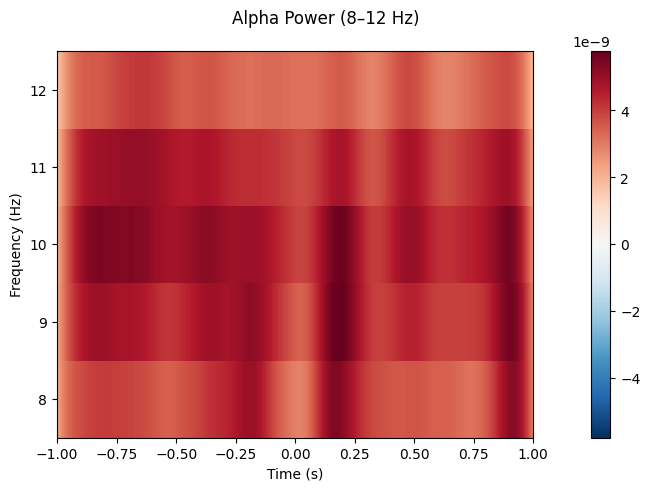

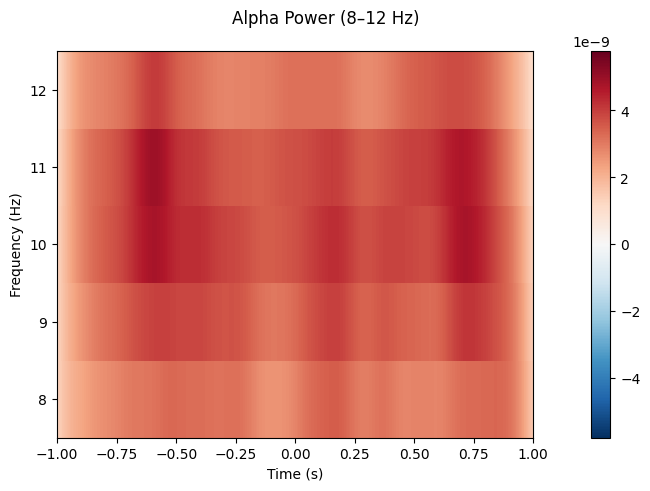

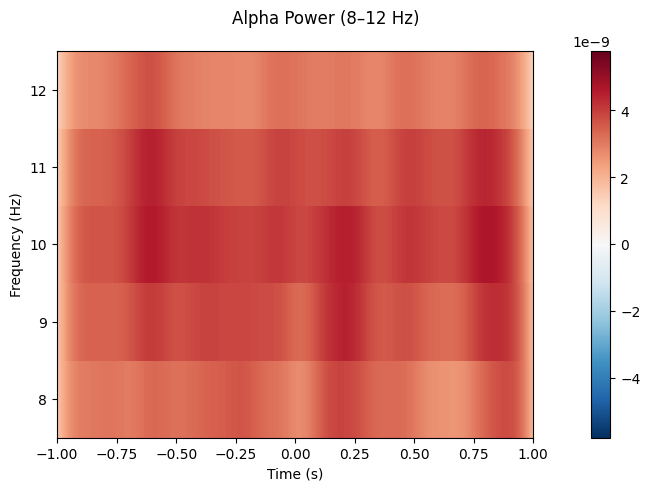

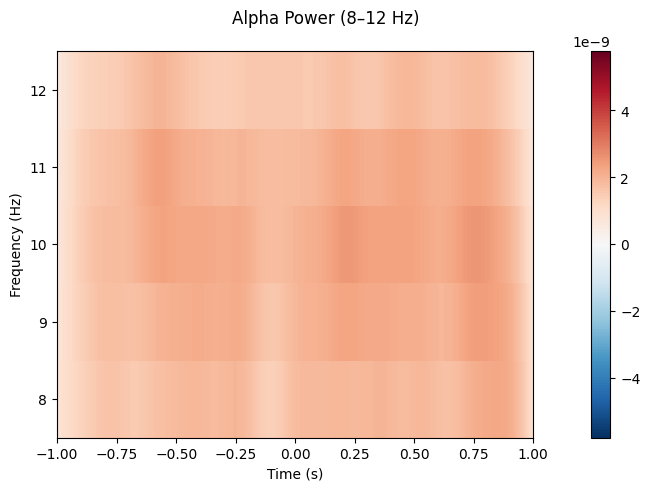

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").



KeyboardInterrupt



In [4]:
# Define frequencies of interest (in Hz)
freqs = np.arange(8, 13, 1)   # Alpha: 8–12 Hz
gamma_freqs = np.arange(30, 46, 2)  # Gamma: 30–45 Hz
n_cycles = freqs / 2.0  # More cycles for better frequency resolution
# Define the electrodes you want to plot
selected_electrodes = ['E59', 'E92', 'E53', 'E87']

# Alpha power
tfr_alpha = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
tfr_alpha.plot(picks=selected_electrodes, title="Alpha Power (8–12 Hz)")

# Gamma power
tfr_gamma = tfr_morlet(epochs, freqs=gamma_freqs, n_cycles=gamma_freqs / 2.0, return_itc=False, average=True)
tfr_gamma.plot(picks=selected_electrodes, title="Gamma Power (30–45 Hz)")


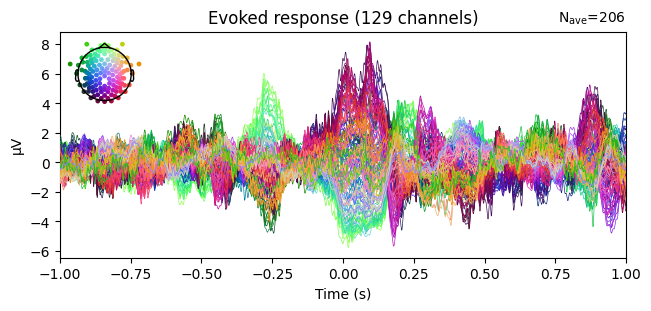

(('E12', 0.08, -5.0304251107677735e-06), ('E77', 0.309, 3.787165931433075e-06))

In [5]:
# Compute evoked response
evoked = epochs.average()
# Plot ERP
evoked.plot(picks="eeg", titles="Evoked response")

# Extract peak amplitude and latency for N1 (~100 ms) and P3 (~300 ms)
#n1_latency, n1_amplitude = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
#p3_latency, p3_amplitude = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

#print(f"N1 Peak: {n1_amplitude:.2f} µV at {n1_latency*1000:.1f} ms")
#print(f"P3 Peak: {p3_amplitude:.2f} µV at {p3_latency*1000:.1f} ms")


peak_results_n1 = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
peak_results_p3 = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
peak_results_n1, peak_results_p3

#p3_latency, p3_amplitude = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

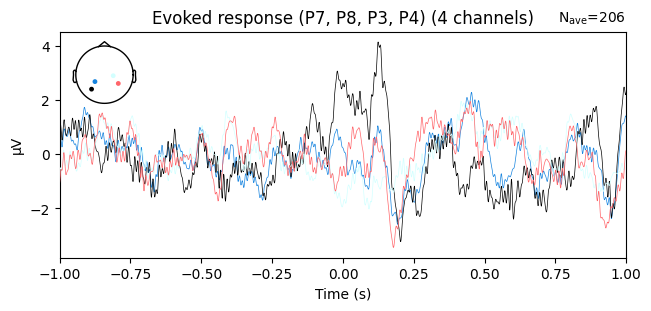

(('E92', 0.178, -3.446999213700715e-06),
 ('E53', 0.454, 2.2946953252938786e-06))

In [6]:
# Pick only electrodes of interest (P7, P8, P3, P4)
selected_electrodes = [59, 92, 53, 87]
picks = ['E53', 'E59', 'E87', 'E92']
# Compute evoked response
evoked = epochs.average(picks=picks)

# Plot ERP for selected channels
evoked.plot(picks=picks, titles="Evoked response (P7, P8, P3, P4)")

# Extract peak amplitude and latency for N1 (~100 ms) and P3 (~300 ms)
peak_results_n1 = evoked.get_peak(tmin=0.08, tmax=0.25, mode='neg', return_amplitude=True)
peak_results_p3 = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
peak_results_n1, peak_results_p3
#print(f"N1 Peak: {n1_amplitude:.2f} µV at {n1_latency*1000:.1f} ms")
#print(f"P3 Peak: {p3_amplitude:.2f} µV at {p3_latency*1000:.1f} ms")


# For loop for multiple participants

In [8]:
conj_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc'
]

# ROIs
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

# Final results
all_measures = []

# Epoch files
#epoch_files = [
 #   "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
  #  "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
#]

epoch_files = glob.glob('/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/*epo.fif')


for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    # Select only conjunction conditions that exist in current file
    existing = [cond for cond in conj_conditions if cond in ep.event_id]
    if not existing:
        print(f"No conjunction conditions found in {filepath}, skipping.")
        continue

    condition_epochs = ep[existing]

    # Average evoked for ROI channels
    evoked = condition_epochs.average(picks=roi_channels)
    # Get N1 (~100ms, negative peak)
    # Get N1 (~100ms, negative peak)
    n1_lat, n1_chan, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
    p3_lat, p3_chan, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
    

    # Compute PSD using multitaper, only EEG channels
    picks = mne.pick_types(condition_epochs.info, eeg=True)
    psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
    psds, freqs = psd.get_data(return_freqs=True)

    # Average across epochs
    avg_psd = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

    # Get correct channel names for picked channels
    picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

    # Create PSD DataFrame
    psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

    # Band power calculation (on frontal ROI)
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        try:
            band_power = psd_df.loc[roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
        except KeyError:
            band_power = None  # If some frontal channels are missing
        band_powers[band_name] = band_power
        
    # Get subject and diagnosis
    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    # Append all measures to list
    all_measures.append({
        'subject': subject_id,
        'diagnosis': diagnosis,
        'N1_amp': n1_amp,
        'N1_lat': n1_chan,
        'N1_chan': n1_lat,
        'P3b_amp': p3_amp,
        'P3b_lat': p3_chan,
        'P3b_chan': p3_lat,
        'alpha_power': band_powers.get('alpha'),
        'gamma_power': band_powers.get('gamma')
    })

# Final DataFrame
results_df = pd.DataFrame(all_measures)
print(results_df)
results_df

Processing /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-0171M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-0171M1_ses-01_task-VS_run-1_eeg_epo.fif ...


    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-0131P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-0131P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation w

KeyboardInterrupt: 

In [32]:
conj_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc'
]

# ROIs
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

# Final results
all_measures = []

# Epoch files
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

for filepath in epoch_files:
    ep = mne.read_epochs(filepath, preload=True)

    # Select only conjunction conditions that exist in current file
    existing = [cond for cond in conj_conditions if cond in ep.event_id]
    if not existing:
        continue

    condition_epochs = ep[existing]

    # Average evoked for ROI channels
    evoked = condition_epochs.average(picks=roi_channels)
    # Get N1 (~100ms, negative peak)
    # Get N1 (~100ms, negative peak)
    n1_lat, n1_chan, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
    p3_lat, p3_chan, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
    

    # Compute PSD using multitaper, only EEG channels
    picks = mne.pick_types(condition_epochs.info, eeg=True)
    psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
    psds, freqs = psd.get_data(return_freqs=True)

    # Average across epochs
    avg_psd = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

    # Get correct channel names for picked channels
    picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

    # Create PSD DataFrame
    psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

    # Band power calculation (on frontal ROI)
    band_powers = {}
    for band_name, (fmin, fmax) in bands.items():
        try:
            band_power = psd_df.loc[roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
        except KeyError:
            band_power = None  # If some frontal channels are missing
        band_powers[band_name] = band_power
        
    # Get subject and diagnosis
    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    # Append all measures to list
    all_measures.append({
        'subject': subject_id,
        'diagnosis': diagnosis,
        'N1_amp': n1_amp,
        'N1_lat': n1_chan,
        'N1_chan': n1_lat,
        'P3b_amp': p3_amp,
        'P3b_lat': p3_chan,
        'P3b_chan': p3_lat,
        'alpha_power': band_powers.get('alpha'),
        'gamma_power': band_powers.get('gamma')
    })

# Final DataFrame
results_df = pd.DataFrame(all_measures)
results_df

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows


,subject,diagnosis,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,-0.000006,0.129,E87,0.000011,0.381,E59,2.973600e-09,1.147995e-10
1,1109M1,control,-0.000004,0.098,E87,0.000003,0.428,E59,7.831558e-10,7.528146e-11


In [33]:
# Condition mapping for easier labeling
conj_conditions = {
    'a5': 'vs/display/search/a5/cc',
    'a9': 'vs/display/search/a9/cc',
    'at': 'vs/display/search/at/cc'
}

# ROIs
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

# Final results
all_measures = []

# Epoch files
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    # Subject info
    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    for condition_label, condition_path in conj_conditions.items():
        if condition_path not in ep.event_id:
            print(f"Condition {condition_path} not found in {filepath}, skipping.")
            continue

        # Get condition-specific epochs
        condition_epochs = ep[condition_path]

        # Evoked for ROI channels
        evoked = condition_epochs.average(picks=roi_channels)

        # N1 and P3b peaks
        n1_lat, n1_chan, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
        p3_lat, p3_chan, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)

        # PSD calculation
        picks = mne.pick_types(condition_epochs.info, eeg=True)
        psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
        psds, freqs = psd.get_data(return_freqs=True)
        avg_psd = psds.mean(axis=0)

        picked_ch_names = [condition_epochs.ch_names[i] for i in picks]
        psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

        # Band powers
        band_powers = {}
        for band_name, (fmin, fmax) in bands.items():
            try:
                band_power = psd_df.loc[roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
            except KeyError:
                band_power = None
            band_powers[band_name] = band_power

        # Store results
        all_measures.append({
            'subject': subject_id,
            'diagnosis': diagnosis,
            'condition': condition_label,
            'N1_amp': n1_amp,
            'N1_lat': n1_lat,
            'N1_chan': n1_chan,
            'P3b_amp': p3_amp,
            'P3b_lat': p3_lat,
            'P3b_chan': p3_chan,
            'alpha_power': band_powers.get('alpha'),
            'gamma_power': band_powers.get('gamma')
        })

# Create final DataFrame
results_df = pd.DataFrame(all_measures)
results_df

Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
 

,subject,diagnosis,condition,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,1109P,asd,a5,-0.000005,E87,0.140,0.000013,E59,0.378,3.243293e-09,1.157568e-10
1,1109P,asd,a9,-0.000007,E87,0.118,0.000012,E59,0.312,2.500041e-09,1.245039e-10
2,1109P,asd,at,-0.000009,E87,0.128,0.000012,E59,0.400,3.056893e-09,1.087700e-10
3,1109M1,control,a5,-0.000003,E53,0.119,0.000005,E59,0.432,6.922079e-10,7.534543e-11
4,1109M1,control,a9,-0.000006,E53,0.125,0.000006,E92,0.397,8.221113e-10,7.696529e-11
5,1109M1,control,at,-0.000005,E59,0.131,0.000002,E87,0.308,8.221502e-10,7.397062e-11


Processing /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


Processing /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s finished


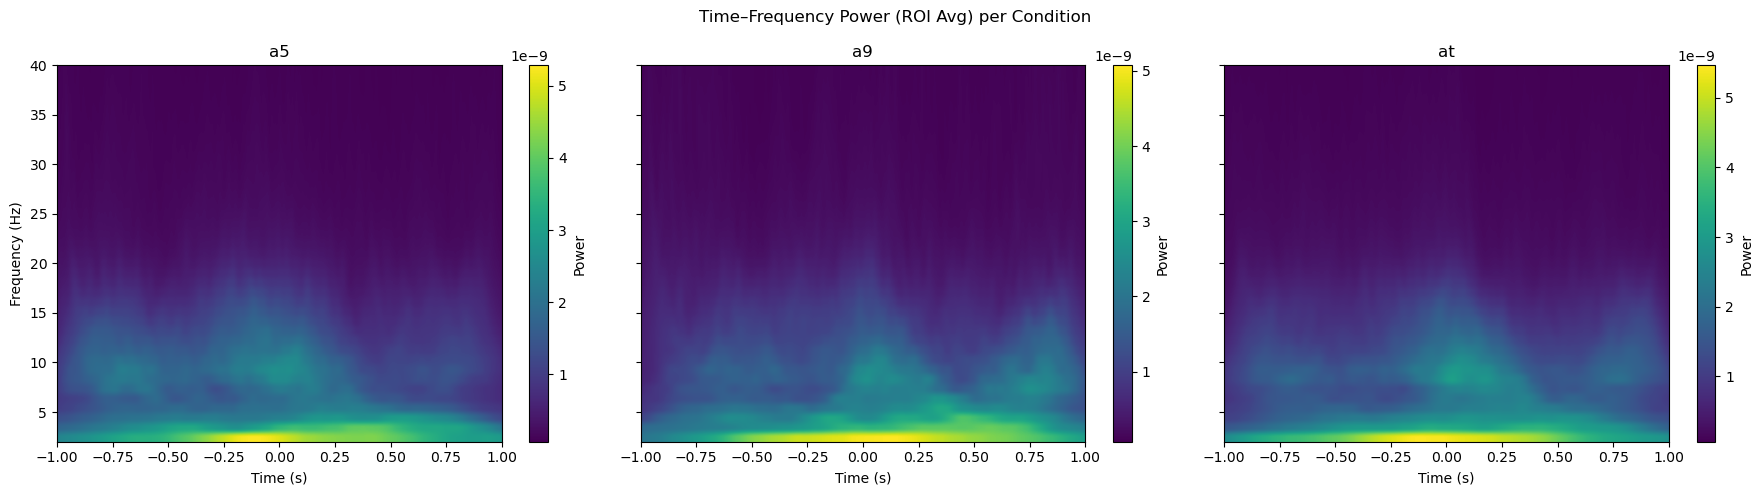

In [27]:
# Define parameters
roi_channels = ['E59', 'E92', 'E53', 'E87']
conj_conditions = ['vs/display/search/a5/cc', 'vs/display/search/a9/cc', 'vs/display/search/at/cc']
epoch_files = [
    "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
    "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
]

# TFR accumulation per condition
condition_tfr_data = {cond: [] for cond in conj_conditions}

for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)
    
    for cond in conj_conditions:
        if cond in ep.event_id:
            cond_epochs = ep[cond].copy().pick_channels(roi_channels)
            
            # Compute TFR using multitaper
            tfr = mne.time_frequency.tfr_multitaper(
                cond_epochs, freqs=np.arange(2, 41, 1), n_cycles=4, use_fft=True,
                return_itc=False, average=True)
            
            # Average across ROI channels
            roi_mean = tfr.data.mean(axis=0)  # shape: (freqs, times)
            condition_tfr_data[cond].append(roi_mean)

# Plot: frequency x time heatmaps for each condition
fig, axes = plt.subplots(1, len(conj_conditions), figsize=(18, 5), sharey=True)
times = tfr.times
freqs = tfr.freqs

for i, cond in enumerate(conj_conditions):
    if condition_tfr_data[cond]:
        mean_power = np.mean(condition_tfr_data[cond], axis=0)  # shape: (freqs, times)
        im = axes[i].imshow(
            mean_power, aspect='auto', origin='lower', 
            extent=[times[0], times[-1], freqs[0], freqs[-1]],
            cmap='viridis'
        )
        axes[i].set_title(cond.split('/')[-2])  # 'a5', 'a9', or 'at'
        axes[i].set_xlabel('Time (s)')
        if i == 0:
            axes[i].set_ylabel('Frequency (Hz)')
        fig.colorbar(im, ax=axes[i], orientation='vertical', label='Power')

plt.suptitle('Time–Frequency Power (ROI Avg) per Condition')
plt.tight_layout()
plt.show()


In [14]:
# Define condition groups
cs_conditions = [
    'vs/display/search/a5/cs',
    'vs/display/search/a9/cs',
    'vs/display/search/at/cs',
]

ca_conditions = [
    'vs/display/search/a5/ca',
    'vs/display/search/a9/ca',
    'vs/display/search/at/ca',
]

conj_conditions = [
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc',
]

condition_sets = {
    'all_conditions': cs_conditions + ca_conditions + conj_conditions,
    'single_conditions': cs_conditions + ca_conditions,
    'conjunction_conditions': conj_conditions,
}

condition_erps = {cond: [] for cond in conj_conditions}



# Conditions by detail 

erp_by_detail = {'single': [], 'conjunction': []}
detail_conditions = {
    'single': ['vs/display/search/a5/cs', 'vs/display/search/a9/cs', 'vs/display/search/at/cs',
               'vs/display/search/a5/ca', 'vs/display/search/a9/ca', 'vs/display/search/at/ca'],
    'conjunction': ['vs/display/search/a5/cc', 'vs/display/search/a9/cc', 'vs/display/search/at/cc']
}



# Create dictionary of error participants and their errors
error_participants = {}
# ROI channels
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 'gamma': (30, 45)}

all_measures = []

#epoch_files = [
 #   "/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif",
  #  "/Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif",
#]

epoch_files = glob.glob('/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/*epo.fif')


for filepath in epoch_files:
    print(f"Processing {filepath}")
    ep = mne.read_epochs(filepath, preload=True)

    subject_id = filepath.split('/')[-1].split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'

    for cond_set_name, cond_list in condition_sets.items():
        # Filter conditions that exist in this file
        existing_conds = [c for c in cond_list if c in ep.event_id]
        if not existing_conds:
            print(f"No {cond_set_name} found in {filepath}, skipping.")
            continue

        condition_epochs = ep[existing_conds]

        # Average evoked for ROI channels
        evoked = condition_epochs.average(picks=roi_channels)
        try:
            n1_lat, n1_chan, n1_amp = evoked.get_peak(tmin=0.08, tmax=0.14, mode='neg', return_amplitude=True)
        except ValueError:
            print(f"No negative peak found for N1 in {filepath}, setting as NaN.")
            n1_lat, n1_chan, n1_amp = np.nan, None, np.nan
            
            # Save participant ID for error tracking
            if subject_id not in error_participants:
                error_participants[subject_id] = []
                error_participants[subject_id].append('N1 peak not found')          

        try:
            p3_lat, p3_chan, p3_amp = evoked.get_peak(tmin=0.3, tmax=0.5, mode='pos', return_amplitude=True)
        except ValueError:
            print(f"No positive peak found for P3b in {filepath}, setting as NaN.")
            p3_lat, p3_chan, p3_amp = np.nan, None, np.nan
            
            # Save participant ID for error tracking
            if subject_id not in error_participants:
                error_participants[subject_id] = []
                error_participants[subject_id].append('P3b peak not found')
                
        # Save detail 
        
        # Re-load epochs just for ERP waveform averaging

    for detail, conds in detail_conditions.items():
        existing = [c for c in conds if c in ep.event_id]
        if not existing:
            print(f"No {detail} conditions found in {filepath}, skipping.")
            if subject_id not in error_participants:
                error_participants[subject_id] = []
                error_participants[subject_id].append(f'{detail} conditions not found')
            continue
        epochs = ep[existing].copy().pick_channels(roi_channels)
        # Average across ROI channels and then across epochs
        erp_data = epochs.get_data().mean(axis=1).mean(axis=0)  # shape: (n_times,)
        erp_by_detail[detail].append(erp_data)
        # Save ERP data
        erp_df = pd.DataFrame(erp_data, columns=['amplitude'])
        erp_df['time'] = epochs.times
        erp_df['subject'] = subject_id
        erp_df['diagnosis'] = diagnosis
        erp_df['detail'] = detail
        erp_by_detail[detail].append(erp_df)
        
        
        # Compute ERPs for conjunction conditions
        for cond in conj_conditions:
            if cond in ep.event_id:
                cond_epochs = ep[cond].copy().pick_channels(roi_channels)
                # Average across ROI channels
                roi_data = cond_epochs.get_data().mean(axis=1)  # shape: (n_epochs, n_times)
                mean_per_sub = roi_data.mean(axis=0)  # shape: (n_times,)
                condition_erps[cond].append(mean_per_sub)
            
        # Compute PSD using multitaper, EEG channels only
        picks = mne.pick_types(condition_epochs.info, eeg=True)
        psd = condition_epochs.compute_psd(method='multitaper', fmin=1, fmax=40, picks=picks)
        psds, freqs = psd.get_data(return_freqs=True)

        # Average across epochs
        avg_psd = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

        picked_ch_names = [condition_epochs.ch_names[i] for i in picks]

        psd_df = pd.DataFrame(avg_psd, index=picked_ch_names, columns=freqs)

        # Band power calculation on ROI channels
        band_powers = {}
        for band_name, (fmin, fmax) in bands.items():
            try:
                band_power = psd_df.loc[roi_channels, (psd_df.columns > fmin) & (psd_df.columns < fmax)].mean().mean()
            except KeyError:
                band_power = None
            band_powers[band_name] = band_power

        # Append results
        all_measures.append({
            'subject': subject_id,
            'diagnosis': diagnosis,
            'condition_set': cond_set_name,
            'N1_amp': n1_amp,
            'N1_lat': n1_lat,
            'N1_chan': n1_chan,
            'P3b_amp': p3_amp,
            'P3b_lat': p3_lat,
            'P3b_chan': p3_chan,
            'alpha_power': band_powers.get('alpha'),
            'gamma_power': band_powers.get('gamma'),
        })

results_df = pd.DataFrame(all_measures)
results_df

Processing /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-0171M1_ses-01_task-VS_run-1_eeg_epo.fif
Reading /project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/sub-0171M1_ses-01_task-VS_run-1_eeg_epo.fif ...


    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
228 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
    Using multitaper spectrum estimation with 7 DPSS windows
Processing /

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(all_measures)
results_df

,subject,diagnosis,condition_set,N1_amp,N1_lat,N1_chan,P3b_amp,P3b_lat,P3b_chan,alpha_power,gamma_power
0,0171M1,control,all_conditions,-7.276864e-07,E87,0.131,0.000001,E59,0.384,4.705472e-11,4.410318e-11
1,0171M1,control,single_conditions,-7.384497e-07,E59,0.095,0.000002,E59,0.384,4.131444e-11,4.442111e-11
2,0171M1,control,conjunction_conditions,-9.583771e-07,E87,0.130,0.000002,E59,0.450,4.924149e-11,4.398206e-11
3,0131P,asd,all_conditions,-5.284950e-06,E92,0.080,0.000017,E59,0.324,1.869318e-09,7.942826e-11
4,0131P,asd,single_conditions,-5.506927e-06,E92,0.108,0.000010,E59,0.347,1.795948e-09,8.436413e-11
5,0131P,asd,conjunction_conditions,-6.589391e-06,E92,0.080,0.000020,E59,0.319,1.897268e-09,7.754793e-11
6,0181F1,control,all_conditions,-4.438955e-06,E59,0.140,0.000002,E59,0.428,2.715778e-10,4.524279e-11
7,0181F1,control,single_conditions,-3.460585e-06,E92,0.115,0.000004,E59,0.464,2.016138e-10,4.599485e-11
8,0181F1,control,conjunction_conditions,-5.147887e-06,E59,0.140,0.000003,E59,0.428,2.982308e-10,4.495629e-11
9,1009M1,control,all_conditions,-3.740292e-06,E53,0.094,0.000003,E92,0.351,2.850122e-10,1.062224e-10


## Plot ERPs for different condition sizes

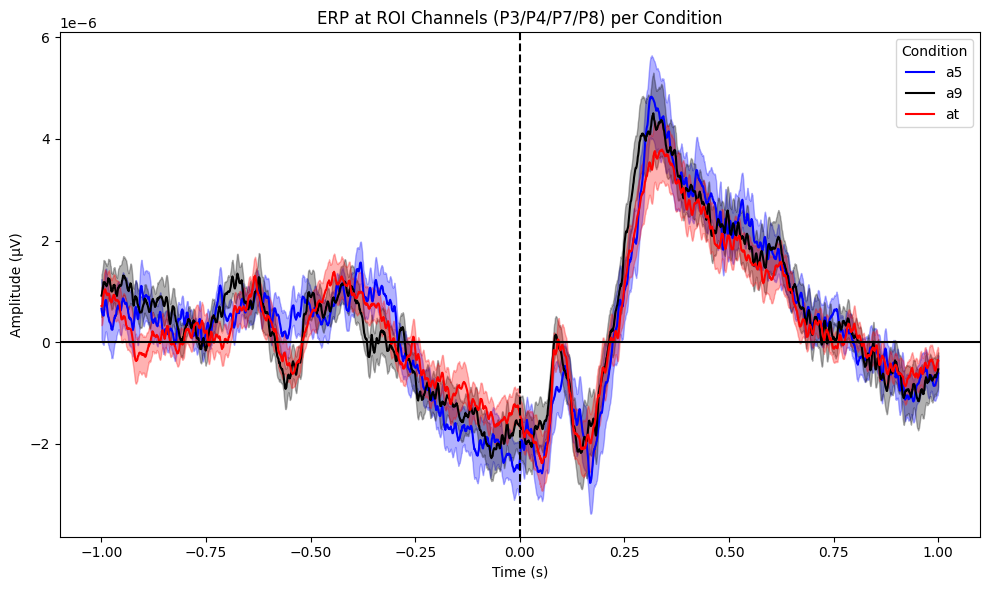

In [ ]:

# Plotting
times = ep.times
plt.figure(figsize=(10, 6))

colors = {
    'vs/display/search/a5/cc': 'blue',
    'vs/display/search/a9/cc': 'black',
    'vs/display/search/at/cc': 'red'
}

for cond, waveforms in condition_erps.items():
    data = np.array(waveforms)  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    
    plt.plot(times, mean, label=cond.split('/')[-2], color=colors[cond])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[cond], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("ERP at ROI Channels (P3/P4/P7/P8) per Condition")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()

## Plot ERPs for single vs conjuction size

Reading /Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
206 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Reading /Users/audrey-annebeaudry/Downloads/sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


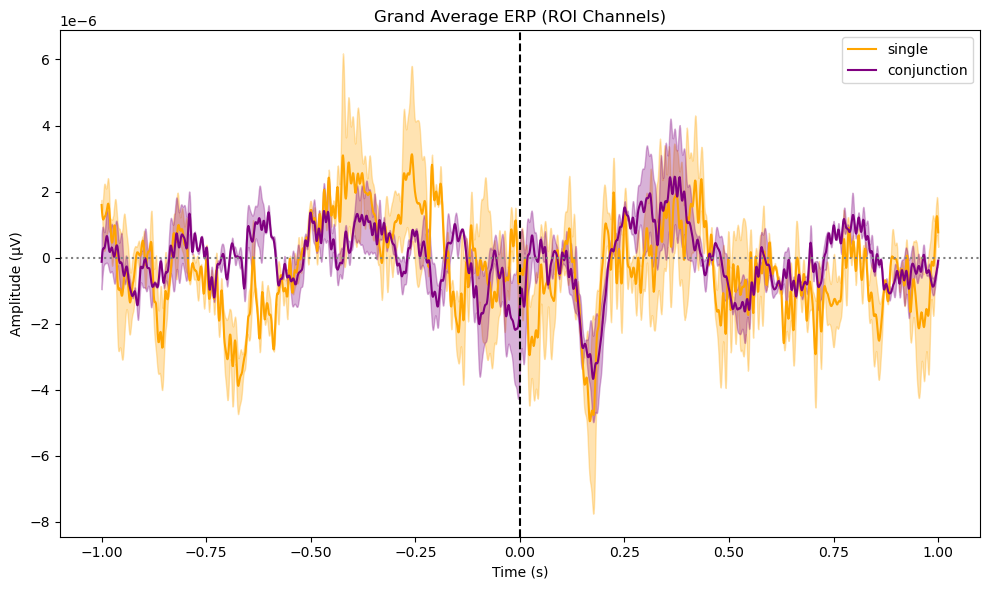

In [ ]:
times = ep.times
plt.figure(figsize=(10, 6))
colors = {'single': 'orange', 'conjunction': 'purple'}

for detail in erp_by_detail:
    data = np.vstack(erp_by_detail[detail])  # shape: (n_subjects, n_times)
    mean = data.mean(axis=0)
    sem = data.std(axis=0) / np.sqrt(data.shape[0])
    plt.plot(times, mean, label=detail, color=colors[detail])
    plt.fill_between(times, mean - sem, mean + sem, color=colors[detail], alpha=0.3)

plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='gray', linestyle=':')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.title("Grand Average ERP (ROI Channels)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Save the results to a CSV file
output_path = '/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/derivatives/grands/code/q1k_latency_VS/VS_results.csv'
results_df.to_csv(output_path, index=False)

### Post revisions version

#### Select conditions

In [ ]:
# Define experimental conditions
single_search_conditions = [  # Combined color search + slice search
    'vs/display/search/a5/cs',  # Color search
    'vs/display/search/a9/cs', 
    'vs/display/search/at/cs',
    'vs/display/search/a5/ca',  # Slice search  
    'vs/display/search/a9/ca',
    'vs/display/search/at/ca',
]

conjunction_search_conditions = [  # Conjunction search (both types)
    'vs/display/search/a5/cc',
    'vs/display/search/a9/cc',
    'vs/display/search/at/cc',
]

# Group conditions for analysis
condition_groups = {
    'single_search': single_search_conditions,
    'conjunction_search': conjunction_search_conditions,
    'all_conditions': single_search_conditions + conjunction_search_conditions
}

# Analysis parameters
baseline_window = (-0.2, 0)  # 200ms pre-stimulus baseline
n1_window = (0.08, 0.14)     # N1 component window
p3_window = (0.3, 0.5)       # P3 component window
min_trials = 10              # Minimum trials per condition

# ROI channels
roi_channels = ['E59', 'E92', 'E53', 'E87']  # P7, P8, P3, P4

# Frequency bands
bands = {'alpha': (8, 13), 
         'gamma': (30, 45)}

file_pattern = '/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/epoch_fif_files/VS/*epo.fif'

# To run locally
#file_pattern= '/Users/audrey-annebeaudry/Downloads/sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif'


#### Get files

In [200]:
epoch_files = glob.glob(file_pattern)
print(f"Found {len(epoch_files)} files to process")

Found 96 files to process


#### Select where to save the data

In [201]:
# Main results storage
all_results = []           # ERP components and spectral power
all_erp_data = []         # ERP waveforms for plotting
quality_issues = defaultdict(list)  # Track data quality problems

# Time-frequency analysis storage
all_tfr_data = []         # Time-frequency representations


#### Helper functions

In [202]:
def extract_subject_info(filepath):
    filename = filepath.split('/')[-1]
    subject_id = filename.split('-')[1].split('_')[0]
    diagnosis = 'asd' if 'P' in subject_id else 'control'
    return subject_id, diagnosis

def compute_spectral_power_mne(epochs, roi_channels, freq_bands):
    """Compute spectral power using MNE functions"""
    # Pick ROI channels
    roi_epochs = epochs.copy().pick_channels(roi_channels)
    
    # Compute PSD using MNE
    psd = roi_epochs.compute_psd(method='welch', fmin=1, fmax=50, verbose=False)
    psds, freqs = psd.get_data(return_freqs=True)
    
    # Average across trials and channels
    avg_psd = psds.mean(axis=(0, 1))  # Shape: (n_freqs,)
    
    # Calculate band power
    band_powers = {}
    for band_name, (fmin, fmax) in freq_bands.items():
        freq_mask = (freqs >= fmin) & (freqs <= fmax)
        if np.any(freq_mask):
            band_power = avg_psd[freq_mask].mean()
            band_powers[f'{band_name}_power'] = band_power
        else:
            band_powers[f'{band_name}_power'] = np.nan
    
    return band_powers



#### Extract data

In [203]:
for i, filepath in enumerate(tqdm(epoch_files, desc="Processing files")):
    print(f"Processing file {i+1}/{len(epoch_files)}: {filepath.split('/')[-1]}")
    
    try:
        # Load epochs
        epochs = mne.read_epochs(filepath, preload=True, verbose=False)
        
        # Get subject info
        subject_id, diagnosis = extract_subject_info(filepath)
        
        
        # Apply baseline correction  
        epochs = epochs.apply_baseline(baseline_window)
        
        # Process each condition group
        for group_name, conditions in condition_groups.items():
            if group_name == 'all_conditions':
                continue
                
            # Find conditions that exist in this dataset
            existing_conditions = [c for c in conditions if c in epochs.event_id]
            
            if not existing_conditions:
                quality_issues[subject_id].append(f"No {group_name} conditions found")
                continue
            
            # Select epochs for this condition group
            condition_epochs = epochs[existing_conditions]
            n_trials = len(condition_epochs)
            
            # Quality control: check minimum trials
            if n_trials < min_trials:
                quality_issues[subject_id].append(f"Low trial count {group_name}: {n_trials}")
                print(f"  Warning: Only {n_trials} trials for {group_name}")
            
            # Select ROI channels and compute evoked response using MNE
            roi_epochs = condition_epochs.copy().pick_channels(roi_channels)
            evoked = roi_epochs.average()
            
            # ERP COMPONENT EXTRACTION USING MNE
            
            # N1 component (negative peak, 80-140ms)
            try:
                n1_channel, n1_lat, n1_amp = evoked.get_peak(
                    tmin=n1_window[0], tmax=n1_window[1], 
                    mode='neg', return_amplitude=True
                )
            except ValueError:
                n1_channel, n1_lat, n1_amp= np.nan, np.nan, np.nan
                quality_issues[subject_id].append(f"N1 not found: {group_name}")
            
            # P3 component (positive peak, 300-500ms) 
            try:
               p3_channel, p3_lat, p3_amp = evoked.get_peak(
                    tmin=p3_window[0], tmax=p3_window[1],
                    mode='pos', return_amplitude=True
                )
            except ValueError:
                p3_channel, p3_lat, p3_amp = np.nan, np.nan, np.nan
                quality_issues[subject_id].append(f"P3 not found: {group_name}")
            
            # SPECTRAL POWER ANALYSIS USING MNE
            
            band_powers = compute_spectral_power_mne(condition_epochs, roi_channels, bands)
            
            # STORE RESULTS
            
            # Store ERP waveform data for plotting
            erp_waveform = {
                'subject': subject_id,
                'diagnosis': diagnosis, 
                'condition_group': group_name,
                'n_trials': n_trials,
                'times': evoked.times,
                'amplitude': evoked.data.mean(axis=0),  # Average across ROI channels
                'roi_channels': ','.join(roi_channels)
            }
            all_erp_data.append(erp_waveform)
            
            # Store summary results
            result = {
                'subject': subject_id,
                'diagnosis': diagnosis,
                'condition_group': group_name, 
                'n_trials': n_trials,
                'roi_channels': ','.join(roi_channels),
                'N1_channel': n1_channel,
                'N1_amplitude': n1_amp,
                'N1_latency': n1_lat,
                'P3_channel': p3_channel,
                'P3_amplitude': p3_amp,
                'P3_latency': p3_lat,
                **band_powers
            }
            all_results.append(result)
    
    except Exception as e:
        print(f"  Error processing {filepath}: {e}")
        subject_id, _ = extract_subject_info(filepath)
        quality_issues[subject_id].append(f"Processing failed: {e}")

print("Main processing completed!")



Processing files:   0%|          | 0/96 [00:00<?, ?it/s]

Processing file 1/96: sub-0171M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   1%|          | 1/96 [00:44<1:10:58, 44.83s/it]

Processing file 2/96: sub-0131P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   2%|▏         | 2/96 [01:15<57:21, 36.61s/it]  

Processing file 3/96: sub-0181F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   3%|▎         | 3/96 [01:45<52:00, 33.55s/it]

Processing file 4/96: sub-1009M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   4%|▍         | 4/96 [02:15<49:05, 32.02s/it]

Processing file 5/96: sub-1083P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   5%|▌         | 5/96 [02:46<48:04, 31.70s/it]

Processing file 6/96: sub-1052F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   6%|▋         | 6/96 [03:11<43:58, 29.31s/it]

Processing file 7/96: sub-0186F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   7%|▋         | 7/96 [03:44<45:37, 30.76s/it]

Processing file 8/96: sub-0068S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   8%|▊         | 8/96 [04:22<48:18, 32.94s/it]

Processing file 9/96: sub-1121S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:   9%|▉         | 9/96 [05:04<51:48, 35.73s/it]

Processing file 10/96: sub-1037F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  10%|█         | 10/96 [05:44<53:00, 36.99s/it]

Processing file 11/96: sub-1147P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  11%|█▏        | 11/96 [06:20<52:17, 36.91s/it]

Processing file 12/96: sub-0196S2_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  12%|█▎        | 12/96 [06:55<50:44, 36.24s/it]

Processing file 13/96: sub-0200S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  14%|█▎        | 13/96 [07:26<47:43, 34.50s/it]

Processing file 14/96: sub-1080M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  15%|█▍        | 14/96 [07:59<46:36, 34.11s/it]

Processing file 15/96: sub-0162M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  16%|█▌        | 15/96 [08:37<47:49, 35.42s/it]

Processing file 16/96: sub-1078P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  17%|█▋        | 16/96 [09:26<52:24, 39.30s/it]

Processing file 17/96: sub-1028S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  18%|█▊        | 17/96 [10:05<51:55, 39.44s/it]

Processing file 18/96: sub-1083S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  19%|█▉        | 18/96 [10:47<52:16, 40.21s/it]

Processing file 19/96: sub-1109M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  20%|█▉        | 19/96 [11:23<49:41, 38.72s/it]

Processing file 20/96: sub-1026M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  21%|██        | 20/96 [12:00<48:23, 38.20s/it]

Processing file 21/96: sub-0104P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  22%|██▏       | 21/96 [12:38<47:47, 38.23s/it]

Processing file 22/96: sub-1009S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  23%|██▎       | 22/96 [13:20<48:35, 39.39s/it]

Processing file 23/96: sub-1147S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  24%|██▍       | 23/96 [13:58<47:32, 39.07s/it]

Processing file 24/96: sub-0134F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  25%|██▌       | 24/96 [14:31<44:30, 37.09s/it]

Processing file 25/96: sub-0171P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  26%|██▌       | 25/96 [15:10<44:49, 37.88s/it]

Processing file 26/96: sub-0131S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  27%|██▋       | 26/96 [15:50<44:51, 38.45s/it]

Processing file 27/96: sub-0265M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  28%|██▊       | 27/96 [16:18<40:25, 35.15s/it]

Processing file 28/96: sub-0183M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  29%|██▉       | 28/96 [16:55<40:33, 35.78s/it]

Processing file 29/96: sub-1042P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  30%|███       | 29/96 [17:29<39:16, 35.17s/it]

Processing file 30/96: sub-1118F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  31%|███▏      | 30/96 [18:01<37:44, 34.30s/it]

Processing file 31/96: sub-1140S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  32%|███▏      | 31/96 [18:35<36:55, 34.09s/it]

Processing file 32/96: sub-0200M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  33%|███▎      | 32/96 [19:08<36:17, 34.02s/it]

Processing file 33/96: sub-0162S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  34%|███▍      | 33/96 [19:44<36:20, 34.61s/it]

Processing file 34/96: sub-0218P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  35%|███▌      | 34/96 [20:17<35:11, 34.06s/it]

Processing file 35/96: sub-0275P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  36%|███▋      | 35/96 [20:44<32:26, 31.91s/it]

Processing file 36/96: sub-0042P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  38%|███▊      | 36/96 [21:17<32:15, 32.25s/it]

Processing file 37/96: sub-0281P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  39%|███▊      | 37/96 [21:50<32:00, 32.55s/it]

Processing file 38/96: sub-0068M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  40%|███▉      | 38/96 [22:22<31:12, 32.29s/it]

Processing file 39/96: sub-1121M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  41%|████      | 39/96 [22:57<31:22, 33.03s/it]

Processing file 40/96: sub-1042F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  42%|████▏     | 40/96 [23:33<31:37, 33.88s/it]

Processing file 41/96: sub-0200P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  43%|████▎     | 41/96 [24:09<31:46, 34.66s/it]

Processing file 42/96: sub-0218M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  44%|████▍     | 42/96 [24:44<31:09, 34.63s/it]

Processing file 43/96: sub-1112M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  45%|████▍     | 43/96 [25:02<26:13, 29.68s/it]

Processing file 44/96: sub-1028S2_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  46%|████▌     | 44/96 [25:41<28:15, 32.61s/it]

Processing file 45/96: sub-0146P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  47%|████▋     | 45/96 [26:20<29:21, 34.54s/it]

Processing file 46/96: sub-1073P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  48%|████▊     | 46/96 [26:55<28:42, 34.44s/it]

Processing file 47/96: sub-1033S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  49%|████▉     | 47/96 [27:35<29:33, 36.19s/it]

Processing file 48/96: sub-1045S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  50%|█████     | 48/96 [28:26<32:34, 40.72s/it]

Processing file 49/96: sub-1006M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  51%|█████     | 49/96 [29:03<31:00, 39.59s/it]

Processing file 50/96: sub-0179M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  52%|█████▏    | 50/96 [29:24<25:57, 33.86s/it]

Processing file 51/96: sub-0093O1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  53%|█████▎    | 51/96 [29:47<23:04, 30.76s/it]

Processing file 52/96: sub-1121P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  54%|█████▍    | 52/96 [30:21<23:11, 31.63s/it]

Processing file 53/96: sub-0062P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  55%|█████▌    | 53/96 [30:55<23:20, 32.56s/it]

Processing file 54/96: sub-0223P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  56%|█████▋    | 54/96 [31:19<20:57, 29.93s/it]

Processing file 55/96: sub-1106M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  57%|█████▋    | 55/96 [31:53<21:08, 30.95s/it]

Processing file 56/96: sub-0186M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  58%|█████▊    | 56/96 [32:12<18:24, 27.61s/it]

Processing file 57/96: sub-0216M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  59%|█████▉    | 57/96 [32:47<19:22, 29.80s/it]

Processing file 58/96: sub-1052M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  60%|██████    | 58/96 [33:26<20:31, 32.40s/it]

Processing file 59/96: sub-1093P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  61%|██████▏   | 59/96 [33:56<19:35, 31.78s/it]

Processing file 60/96: sub-1147F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  62%|██████▎   | 60/96 [34:31<19:42, 32.85s/it]

Processing file 61/96: sub-1024M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  64%|██████▎   | 61/96 [35:03<18:53, 32.38s/it]

Processing file 62/96: sub-1067S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  65%|██████▍   | 62/96 [35:40<19:08, 33.79s/it]

Processing file 63/96: sub-0181M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  66%|██████▌   | 63/96 [36:13<18:27, 33.58s/it]

Processing file 64/96: sub-1078F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  67%|██████▋   | 64/96 [36:38<16:34, 31.07s/it]

Processing file 65/96: sub-0064M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  68%|██████▊   | 65/96 [37:06<15:37, 30.23s/it]

Processing file 66/96: sub-1134S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  69%|██████▉   | 66/96 [37:39<15:28, 30.94s/it]

Processing file 67/96: sub-0171F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  70%|██████▉   | 67/96 [38:11<15:08, 31.34s/it]

Processing file 68/96: sub-1121F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  71%|███████   | 68/96 [38:42<14:36, 31.30s/it]

Processing file 69/96: sub-1033P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  72%|███████▏  | 69/96 [39:18<14:42, 32.68s/it]

Processing file 70/96: sub-1042M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  73%|███████▎  | 70/96 [39:55<14:39, 33.82s/it]

Processing file 71/96: sub-1109P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  74%|███████▍  | 71/96 [40:18<12:43, 30.54s/it]

Processing file 72/96: sub-0281M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  75%|███████▌  | 72/96 [40:51<12:33, 31.40s/it]

Processing file 73/96: sub-0068F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  76%|███████▌  | 73/96 [41:20<11:47, 30.75s/it]

Processing file 74/96: sub-0196M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  77%|███████▋  | 74/96 [41:51<11:15, 30.70s/it]

Processing file 75/96: sub-0265P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  78%|███████▊  | 75/96 [42:24<10:57, 31.30s/it]

Processing file 76/96: sub-1061S3_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  79%|███████▉  | 76/96 [42:52<10:08, 30.43s/it]

Processing file 77/96: sub-1114P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  80%|████████  | 77/96 [43:25<09:50, 31.08s/it]

Processing file 78/96: sub-1073M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  81%|████████▏ | 78/96 [43:59<09:35, 31.95s/it]

Processing file 79/96: sub-0200F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  82%|████████▏ | 79/96 [44:30<08:59, 31.73s/it]

Processing file 80/96: sub-1033M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  83%|████████▎ | 80/96 [45:02<08:31, 31.99s/it]

Processing file 81/96: sub-1057F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  84%|████████▍ | 81/96 [45:40<08:24, 33.62s/it]

Processing file 82/96: sub-0129M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  85%|████████▌ | 82/96 [46:18<08:08, 34.91s/it]

Processing file 83/96: sub-1024P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  86%|████████▋ | 83/96 [46:42<06:52, 31.77s/it]

Processing file 84/96: sub-1118M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  88%|████████▊ | 84/96 [47:16<06:30, 32.51s/it]

Processing file 85/96: sub-1061F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  89%|████████▊ | 85/96 [47:55<06:18, 34.44s/it]

Processing file 86/96: sub-0064S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  90%|████████▉ | 86/96 [48:26<05:34, 33.41s/it]

Processing file 87/96: sub-1143F1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  91%|█████████ | 87/96 [49:01<05:03, 33.73s/it]

Processing file 88/96: sub-0248M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  92%|█████████▏| 88/96 [49:30<04:18, 32.25s/it]

Processing file 89/96: sub-0134M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  93%|█████████▎| 89/96 [50:05<03:52, 33.26s/it]

Processing file 90/96: sub-1118P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  94%|█████████▍| 90/96 [50:35<03:14, 32.35s/it]

Processing file 91/96: sub-0223M1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  95%|█████████▍| 91/96 [50:52<02:17, 27.47s/it]

Processing file 92/96: sub-0068S3_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  96%|█████████▌| 92/96 [51:17<01:47, 26.92s/it]

Processing file 93/96: sub-1147S2_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  97%|█████████▋| 93/96 [51:48<01:24, 28.06s/it]

Processing file 94/96: sub-0179P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  98%|█████████▊| 94/96 [52:19<00:58, 29.03s/it]

Processing file 95/96: sub-0162P_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files:  99%|█████████▉| 95/96 [52:51<00:29, 29.73s/it]

Processing file 96/96: sub-1052S1_ses-01_task-VS_run-1_eeg_epo.fif
Applying baseline correction (mode: mean)
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Processing files: 100%|██████████| 96/96 [52:57<00:00, 33.10s/it]

Main processing completed!


### Create dataframe with ERP info 

In [204]:
# Convert results to DataFrames
results_df = pd.DataFrame(all_results)
print(f"\nProcessed {results_df['subject'].nunique()} subjects")

# Create ERP waveform DataFrame for plotting
erp_data_list = []
for erp_dict in all_erp_data:
    n_timepoints = len(erp_dict['times'])
    erp_df = pd.DataFrame({
        'time': erp_dict['times'],
        'amplitude': erp_dict['amplitude'],
        'subject': [erp_dict['subject']] * n_timepoints,
        'diagnosis': [erp_dict['diagnosis']] * n_timepoints,
        'condition_group': [erp_dict['condition_group']] * n_timepoints,
        'n_trials': [erp_dict['n_trials']] * n_timepoints
    })
    erp_data_list.append(erp_df)

if erp_data_list:
    erp_df = pd.concat(erp_data_list, ignore_index=True)
    print(f"ERP waveform data: {len(erp_df)} timepoints")
else:
    erp_df = pd.DataFrame()
    print("No ERP waveform data available")


Processed 96 subjects
ERP waveform data: 384192 timepoints


In [205]:
results_df

,subject,diagnosis,condition_group,n_trials,roi_channels,N1_channel,N1_amplitude,N1_latency,P3_channel,P3_amplitude,P3_latency,alpha_power,gamma_power
0,0171M1,control,single_search,8,"E59,E92,E53,E87",E87,-6.087771e-07,0.140,E59,0.000003,0.384,4.108853e-14,4.630650e-14
1,0171M1,control,conjunction_search,21,"E59,E92,E53,E87",E87,-7.847545e-07,0.130,E59,0.000002,0.450,5.509481e-14,4.197132e-14
2,0131P,asd,single_search,8,"E59,E92,E53,E87",E92,-5.028659e-06,0.108,E92,0.000007,0.401,2.060469e-12,7.351868e-14
3,0131P,asd,conjunction_search,21,"E59,E92,E53,E87",E92,-4.171453e-06,0.080,E59,0.000024,0.319,2.349072e-12,6.683588e-14
4,0181F1,control,single_search,8,"E59,E92,E53,E87",E92,-2.457708e-06,0.115,E92,0.000004,0.430,2.744544e-13,4.436825e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0179P,asd,conjunction_search,21,"E59,E92,E53,E87",E87,-2.589790e-06,0.094,E92,0.000010,0.307,5.580485e-13,5.279615e-14
188,0162P,asd,single_search,7,"E59,E92,E53,E87",E87,-4.216424e-06,0.129,E92,0.000010,0.302,1.275722e-12,4.851086e-14
189,0162P,asd,conjunction_search,21,"E59,E92,E53,E87",E59,-5.096566e-06,0.088,E92,0.000009,0.393,1.470207e-12,5.909632e-14
190,1052S1,control,single_search,4,"E59,E92,E53,E87",E92,-7.395075e-06,0.115,E59,0.000016,0.439,2.685232e-12,1.678350e-13


#### Check number of issues with processes data

In [206]:
if quality_issues:
    for subject, issues in quality_issues.items():
        print(f"\nSubject {subject}:")
        for issue in issues:
            print(f"  - {issue}")
else:
    print("No quality issues detected!")

# Summary statistics
print(f"\nSUMMARY:")
print(f"- Total subjects processed: {results_df['subject'].nunique()}")
print(f"- Subjects with issues: {len(quality_issues)}")
print(f"- Average trials per condition: {results_df['n_trials'].mean():.1f}")
print(f"- Minimum trials: {results_df['n_trials'].min()}")


Subject 0171M1:
  - Low trial count single_search: 8

Subject 0131P:
  - Low trial count single_search: 8

Subject 0181F1:
  - Low trial count single_search: 8

Subject 1009M1:
  - Low trial count single_search: 8

Subject 1083P:
  - Low trial count single_search: 8

Subject 1052F1:
  - Low trial count single_search: 6

Subject 0186F1:
  - Low trial count single_search: 7

Subject 0068S1:
  - Low trial count single_search: 8

Subject 1121S1:
  - Low trial count single_search: 8

Subject 1037F1:
  - Low trial count single_search: 8

Subject 1147P:
  - Low trial count single_search: 8

Subject 0196S2:
  - Low trial count single_search: 8
  - N1 not found: single_search

Subject 0200S1:
  - Low trial count single_search: 7

Subject 1080M1:
  - Low trial count single_search: 7

Subject 0162M1:
  - Low trial count single_search: 7

Subject 1078P:
  - Low trial count single_search: 5

Subject 1028S1:
  - Low trial count single_search: 8

Subject 1083S1:
  - Low trial count single_search: 8


#### Plot ERP differences between conditions 

/tmp/ipykernel_3890482/1337170902.py:24: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = plot_compare_evokeds(evoked_dict, picks='ROI',


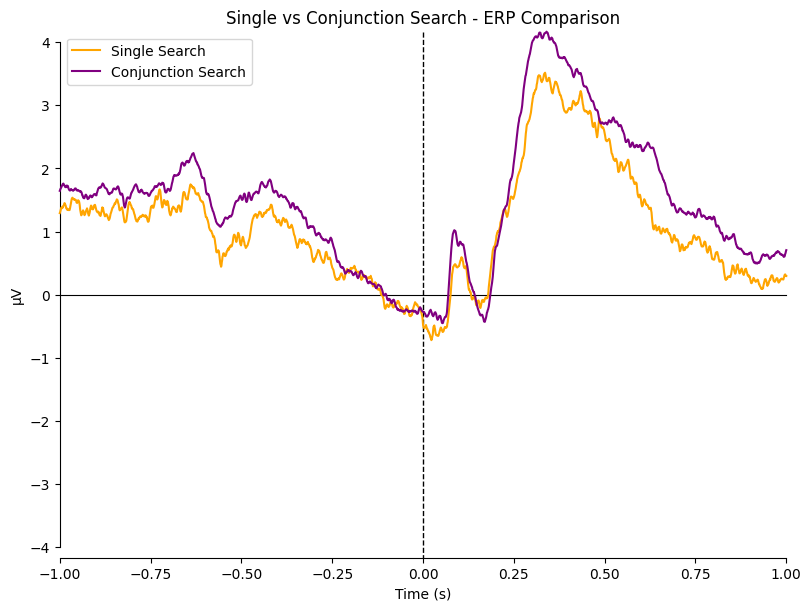

In [207]:
if not erp_df.empty:
    
    # Create evoked objects for each condition
    evoked_dict = {}
    
    for condition in ['single_search', 'conjunction_search']:
        condition_data = erp_df[erp_df['condition_group'] == condition]
        
        if not condition_data.empty:
            # Compute grand average
            grand_avg = condition_data.groupby('time')['amplitude'].mean()
            times = grand_avg.index.values
            data = grand_avg.values.reshape(1, -1)  # Shape: (1 channel, n_times)
            
            # Create minimal info structure
            info = mne.create_info(['ROI'], sfreq=1000, ch_types=['eeg'])
            
            # Create evoked object
            evoked = mne.EvokedArray(data, info, tmin=times[0])
            evoked_dict[condition.replace('_', ' ').title()] = evoked
    
    if len(evoked_dict) == 2:
        # Plot comparison using MNE
        fig = plot_compare_evokeds(evoked_dict, picks='ROI', 
                                  title='Single vs Conjunction Search - ERP Comparison',
                                   colors=['orange', 'purple'], ci=True, show='separate', show_sensors='upper right')
        plt.show()


### Plot differences between ASD and Controls in conjuction

/tmp/ipykernel_3890482/1168282890.py:26: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  fig = plot_compare_evokeds(evoked_dict, picks='ROI',


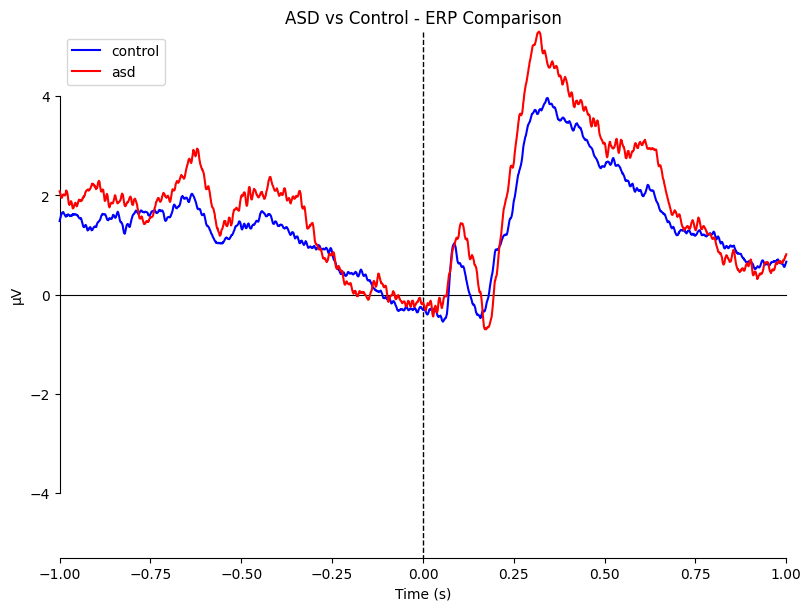

In [208]:
# Plot group differences
if not erp_df.empty:
    
    # Create evoked objects for each condition
    evoked_dict = {}
    
    for diagnosis in results_df['diagnosis'].unique():
        condition_data = erp_df[erp_df['diagnosis'] == diagnosis]
        
        # Select only conjunction conditions
        condition_data = condition_data[condition_data['condition_group'] == 'conjunction_search']
        
        if not condition_data.empty:
            # Compute grand average
            grand_avg = condition_data.groupby('time')['amplitude'].mean()
            times = grand_avg.index.values
            data = grand_avg.values.reshape(1, -1)
            # Create minimal info structure
            info = mne.create_info(['ROI'], sfreq=1000, ch_types=['eeg'])  
            
            # Create evoked object
            evoked = mne.EvokedArray(data, info, tmin=times[0])
            evoked_dict[diagnosis] = evoked
    if len(evoked_dict) == 2:
        # Plot comparison using MNE
        fig = plot_compare_evokeds(evoked_dict, picks='ROI', 
                                  title='ASD vs Control - ERP Comparison',
                                   colors=['blue', 'red'], ci=True, show='separate', show_sensors='upper right')
        plt.show()

#### Spectral power comparison

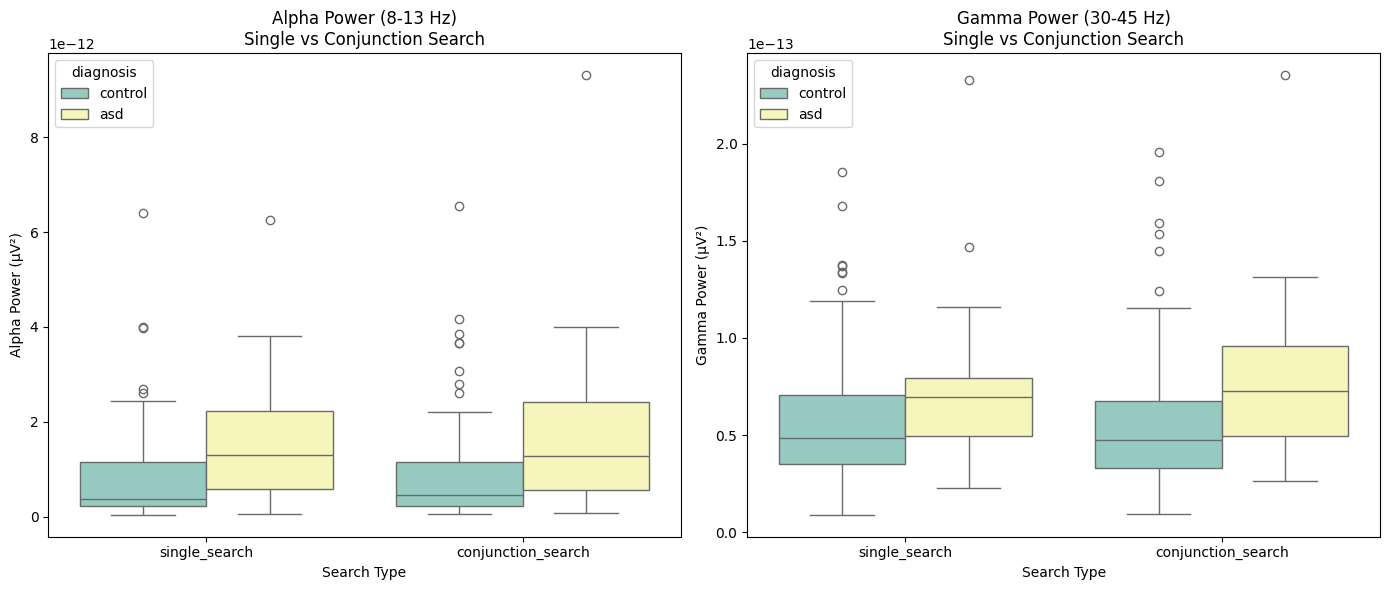

In [209]:
if not results_df.empty:
    # Alpha vs Gamma power comparison between conditions
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Alpha power
    ax1 = axes[0]
    valid_alpha = results_df.dropna(subset=['alpha_power'])
    if not valid_alpha.empty:
        sns.boxplot(data=valid_alpha, x='condition_group', y='alpha_power', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('Alpha Power (8-13 Hz)\nSingle vs Conjunction Search')
        ax1.set_ylabel('Alpha Power (μV²)')
        ax1.set_xlabel('Search Type')

    # Gamma power
    ax2 = axes[1]
    valid_gamma = results_df.dropna(subset=['gamma_power'])
    if not valid_gamma.empty:
        sns.boxplot(data=valid_gamma, x='condition_group', y='gamma_power', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('Gamma Power (30-45 Hz)\nSingle vs Conjunction Search')
        ax2.set_ylabel('Gamma Power (μV²)')
        ax2.set_xlabel('Search Type')
        

    plt.tight_layout()
    plt.show()



### Amplitude differences

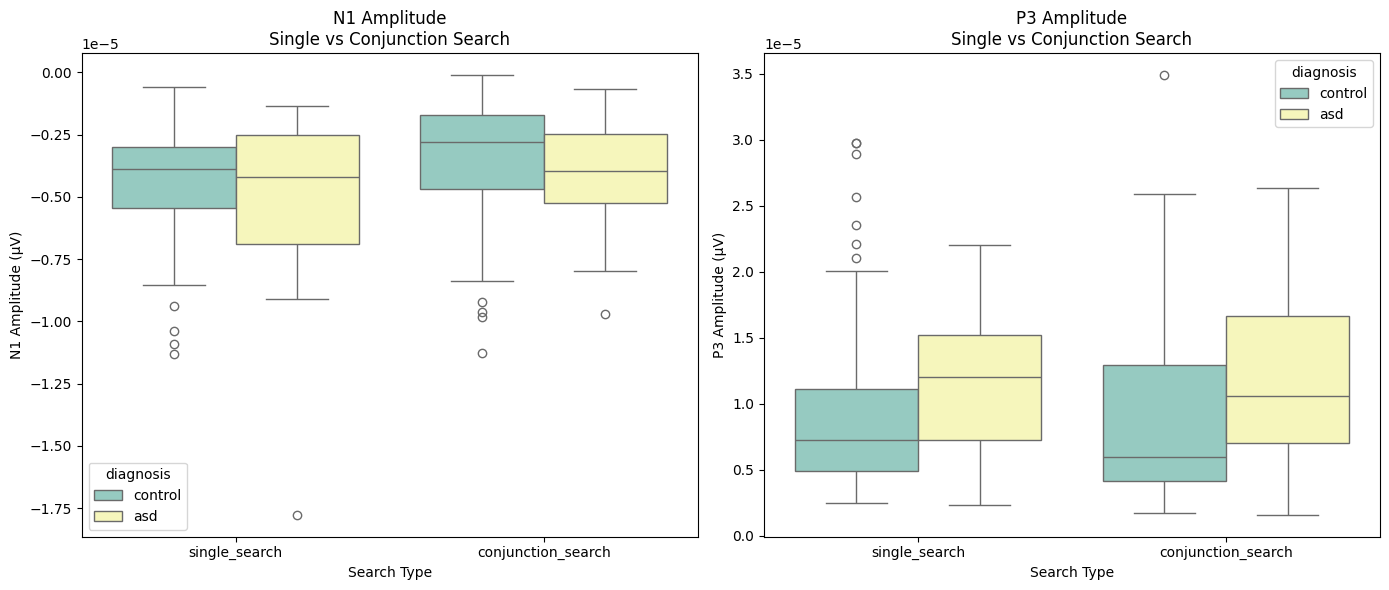

In [210]:
# Plot differences in N1 and P3 amplitudes
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # N1 amplitude
    ax1 = axes[0]
    valid_n1 = results_df.dropna(subset=['N1_amplitude'])
    if not valid_n1.empty:
        sns.boxplot(data=valid_n1, x='condition_group', y='N1_amplitude', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('N1 Amplitude\nSingle vs Conjunction Search')
        ax1.set_ylabel('N1 Amplitude (μV)')
        ax1.set_xlabel('Search Type')

    # P3 amplitude
    ax2 = axes[1]
    valid_p3 = results_df.dropna(subset=['P3_amplitude'])
    if not valid_p3.empty:
        sns.boxplot(data=valid_p3, x='condition_group', y='P3_amplitude', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('P3 Amplitude\nSingle vs Conjunction Search')
        ax2.set_ylabel('P3 Amplitude (μV)')
        ax2.set_xlabel('Search Type')

    plt.tight_layout()
    plt.show()

#### Latency differences

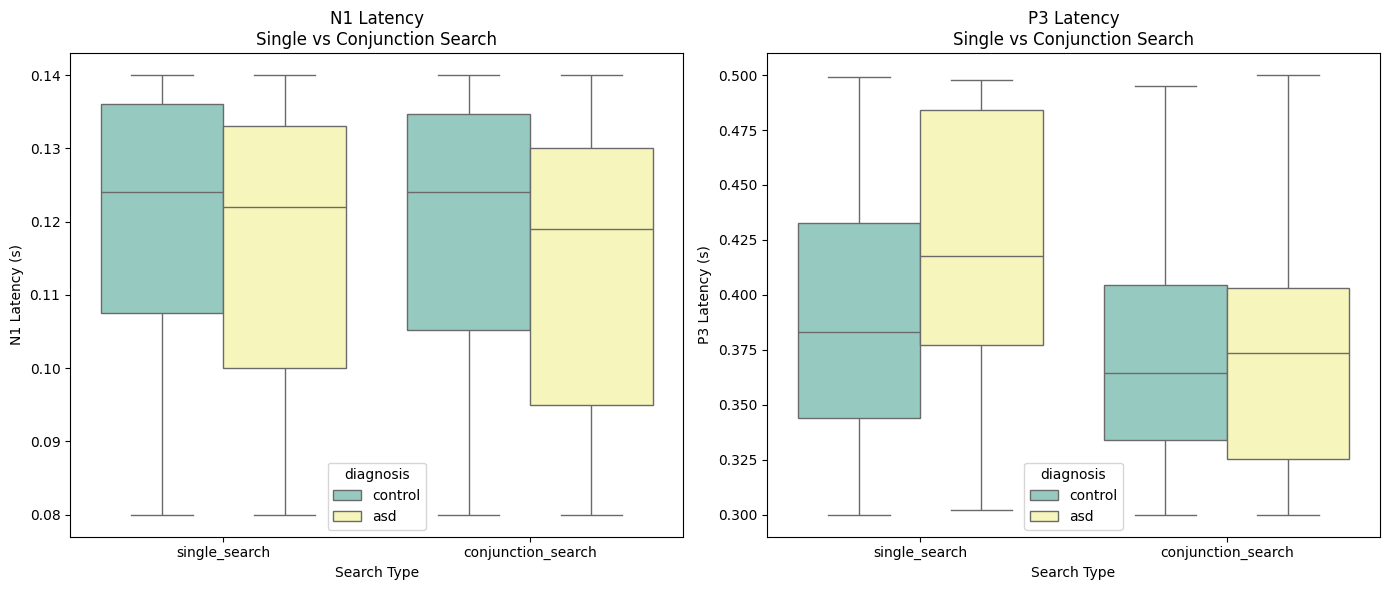

In [211]:
# Plotting differences in N1 and P3 latencies   
if not results_df.empty:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # N1 latency
    ax1 = axes[0]
    valid_n1 = results_df.dropna(subset=['N1_latency'])
    if not valid_n1.empty:
        sns.boxplot(data=valid_n1, x='condition_group', y='N1_latency', ax=ax1, hue='diagnosis', palette='Set3')
        ax1.set_title('N1 Latency\nSingle vs Conjunction Search')
        ax1.set_ylabel('N1 Latency (s)')
        ax1.set_xlabel('Search Type')

    # P3 latency
    ax2 = axes[1]
    valid_p3 = results_df.dropna(subset=['P3_latency'])
    if not valid_p3.empty:
        sns.boxplot(data=valid_p3, x='condition_group', y='P3_latency', ax=ax2, hue='diagnosis', palette='Set3')
        ax2.set_title('P3 Latency\nSingle vs Conjunction Search')
        ax2.set_ylabel('P3 Latency (s)')
        ax2.set_xlabel('Search Type')

    plt.tight_layout()
    plt.show()

In [212]:
# Save the results to a CSV file
output_path = '/project/def-emayada/gabe030/Q1K_EXPERIMENTAL_COPY/experimental/derivatives/pylossless/derivatives/sync_loss/derivatives/segment/derivatives/autorej/derivatives/grands/code/q1k_latency_VS/VS_results.csv'
results_df.to_csv(output_path, index=False)

#### Inspect events in one participant


In [ ]:
def inspect_participant(filepath, show_events=True, show_epochs_info=True):

    print(f"Inspecting participant: {filepath.split('/')[-1]}")
    
    try:
        # Load epochs
        epochs = mne.read_epochs(filepath, preload=True, verbose=False)
        
        # Extract subject info
        filename = filepath.split('/')[-1]
        subject_id = filename.split('-')[1].split('_')[0]
        diagnosis = 'asd' if 'P' in subject_id else 'control'
        
        print(f"Subject ID: {subject_id}")
        print(f"Diagnosis: {diagnosis}")
        print(f"Number of channels: {len(epochs.ch_names)}")
        print(f"Sampling rate: {epochs.info['sfreq']} Hz")
        print(f"Total epochs: {len(epochs)}")
        print(f"Epoch duration: {epochs.times[0]:.3f} to {epochs.times[-1]:.3f} seconds")
        
        # Print all the event IDs
        print(f"\nEvent IDs:")
        for event_id, label in epochs.event_id.items():
            print(f"  {event_id}: {label} ({len(epochs[event_id])} epochs)")
            
        
        if show_events:
            # Show condition groupings with quality assessment
            print(f"\nCondition groupings:")
            print("-" * 30)
            for group_name, conditions in condition_groups.items():
                if group_name == 'all_conditions':
                    continue
                existing_conditions = [c for c in conditions if c in epochs.event_id]
                if existing_conditions:
                    total_trials = sum(len(epochs[c]) for c in existing_conditions)
                    
                    # Quality assessment for grouped conditions
                    if total_trials >= 10:
                        quality = "✓ Good for ERP"
                    else:
                        quality = "✗ Insufficient"
                    
                    print(f"  {group_name}: {total_trials} trials ({quality})")
                    for cond in existing_conditions:
                        print(f"    - {cond}: {len(epochs[cond])} trials")
                else:
                    print(f"  {group_name}: 0 trials (no matching conditions)")
        
        if show_epochs_info:
            print(f"\nEpochs info:")
            print(epochs.info)
            
        # Plot events using MNE
        print(f"\nPlotting events timeline...")
        
        # Plot only events that are in the condition groups
        valid_events = [event for event in epochs.events if event[2] in epochs.event_id]
        if not valid_events:
            print("No valid events found for plotting.")
            return None, None, None
        fig = mne.viz.plot_events(valid_events, sfreq=epochs.info['sfreq'],
                                  event_id=epochs.event_id, title=f"Events for {subject_id}", 
                                  show=False)
        fig.set_size_inches(12, 6)
        plt.title(f"Events Timeline - {subject_id}")
        plt.show()
        
        return epochs, subject_id, diagnosis
        
    except Exception as e:
        print(f"Error inspecting participant: {e}")
        return None, None, None

In [ ]:
if epoch_files:
    example_epochs, example_subject, example_diagnosis = inspect_participant(epoch_files[0])
else:
    print("No files found to inspect")

Inspecting participant: sub-0171M1_ses-01_task-VS_run-1_eeg_epo.fif


KeyboardInterrupt: 